In [1]:
import pyedflib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import scipy.signal

In [25]:
import pdb

In [4]:
f = pyedflib.EdfReader(r"D:\data\FCDataAnalysis\zhaoyunfengsz1.edf")
n = f.signals_in_file
signal_labels = f.getSignalLabels()
record = np.zeros((n, f.getNSamples()[0]))
for i in np.arange(n):
    record[i, :] = f.readSignal(i)

In [11]:
sampleFreq = f.getSampleFrequency(1)
signalSam = f.getNSamples()[1]
sigDur = f.getFileDuration()

In [83]:
#pdb.set_trace()
def h2_modify(x,y,L=7):
    '''
    x,y 代表两个信号
    L代表区间线
    该函数返回每个区间的Q、P值
    ''' 
    
    '''
    q1,q3=np.percentile(x,[25,75]) 
    condition = (q3-q1)*2  #默认是1.5倍 x-q3 > c or q1 - x > c
    outliers1 = np.where(x>condition+q3)[0]
    outliers2 = np.where(x<q1-condition)[0]
    x =  np.delete(x,np.r_[outliers1,outliers2])
    y =  np.delete(y,np.r_[outliers1,outliers2])
    '''
    
    min_x = np.min(x)-0.00000001
    max_x = np.max(x)
    lx = len(x)
    bins=np.linspace(min_x,max_x,L)  
    Q=[]
    P=[] # 6
    k=[] # 5
    f=[]
    Qy=[None]*(L-1)
    for i in range(L-1):
        Qy[i] = []
        
    for xi in range(lx):
        for li in range(L-1):
            if bins[li] < x[xi] <=bins[li+1]:
                Qy[li].append(y[xi])
                break
    
    for i in range(L-1):
        if len(Qy[i]):
            Q.append(np.mean(Qy[i]))
            P.append((bins[i]+bins[i+1])/2) 
            if i:
                k.append((Q[i]-Q[i-1])/(P[i]-P[i-1]))
        else:
            q1,q3=np.percentile(x,[25,75]) 
            condition = (q3-q1)*2  #默认是1.5倍 x-q3 > c or q1 - x > c
            outliers1 = np.where(x>condition+q3)[0]
            outliers2 = np.where(x<q1-condition)[0]
            x =  np.delete(x,np.r_[outliers1,outliers2])
            y =  np.delete(y,np.r_[outliers1,outliers2])
            return h2_modify(x,y,L)

    px=P.copy()
    px[0]=min_x
    px[L-2]=max_x
    
    for xi in x:
        for li in range(L-2):
            if px[li] < xi <= px[li+1]:
                fx=k[li]*(xi-P[li])+Q[li]
                f.append(fx)
                break
  
    #f = np.array(f) 当长度相等，可以不加
    my=np.mean(y)
    sst=np.sum((y-my)**2)
    sse=np.sum((y-f)**2)
    h2=1-sse/sst   
    return h2

In [6]:
def H2_filter(signals,start_time,duration,sampleFreq,slideWindow=2,step=1,maxlag=0.1,L=7,HP=0,LP=0):
    '''
    在H2_whole3方法的基础上增加filter功能
    signals：原始信号，numpy矩阵类型（二维矩阵）
    slideWindows:滑动窗口
    duration：信号的持续时间
    HP，LP：接收归一化截止频率
    '''
    #time_flexity=1
    signals_num = len(signals)
    if signals_num < 2:
        print("Please input at least 2 signals to compute h2!")
        return None,None
    
    h2_num = int((duration-slideWindow-maxlag)//step + 1)
    if h2_num <= 0:
        print("Duration is too short to compute h2!")
        return None,None
    
    if maxlag <= 0:
        print("Time maxlag must be greater than zero!")
        
    b = a = []
    if HP==0 and LP>0: #低通
        b,a = scipy.signal.butter(2,2*LP/sampleFreq,"lowpass")
    elif LP==0 and HP>0: #高通
        b,a = scipy.signal.butter(2,2*HP/sampleFreq,"highpass")
    elif LP>0 and HP>0: #带通
        b,a = scipy.signal.butter(2,[2*HP/sampleFreq,2*LP/sampleFreq],"bandpass")
    
    h2_value = []
    lag_value = []
    
     # 计算每次窗口滑动时的H2（每个时间段）
    for ti in range(h2_num):
        start_time_window = start_time + ti*step
        stop_time_window = start_time_window + slideWindow
        start_samples = int(start_time_window*sampleFreq)
        stop_samples = int(stop_time_window*sampleFreq)
        # 对角线上的值设置为 0
        signals_h2 = np.zeros((signals_num,signals_num))
        signals_lag = np.zeros((signals_num,signals_num))
        # 计算每两个信号之间的H2: (0,1)，(0,2)，...，(0,n-1)；(1,2)，(1,3)，...，(1,n-1)；...(n-2,n-1)
        for si1 in range(signals_num-1):
            s1 = signals[si1][start_samples:stop_samples]
            if len(a):
                s1 = scipy.signal.filtfilt(b,a,s1)
            # [s1] = setSignaltoZero([signals[si1][start_samples:stop_samples]]) # 做归0处理
            for si2 in range(si1+1,signals_num):
                s2 = signals[si2][start_samples:stop_samples]
                if len(a):
                    s2 = scipy.signal.filtfilt(b,a,s2)
                #[s2] = setSignaltoZero([signals[si2][start_samples:stop_samples]])
                # 设置两个信号之间的H2的初始值为0
                two_signals_h2 = np.zeros(2) 
                two_signals_lag = np.zeros(2) 
                
                h2_00 = [h2_modify(s1,s2,L),h2_modify(s2,s1,L)]
                #time_flexity += 1
                two_signals_h2[0] = h2_00[0]
                two_signals_h2[1] = h2_00[1]
                # 考虑时间延迟
                # 计算x到y
                sample_maxlag = int(maxlag*sampleFreq)
                for tagi in range(1,sample_maxlag): # x向右移动，符号为正；y向右移动，符号为负
                    #print(start_samples,stop_samples)
                    #time_flexity += 2
                    s1m = signals[si1][start_samples+tagi:stop_samples+tagi]
                    s2m = signals[si2][start_samples+tagi:stop_samples+tagi]
                    #[s1m,s2m] = setSignaltoZero([s1m,s2m],1)  # 做归0处理
                    
                    h2_mn = [h2_modify(s1m,s2,L),h2_modify(s2,s1m,L)] # s1向右移  H2(s1m,s2,L)
                    h2_nm = [h2_modify(s1,s2m,L),h2_modify(s2m,s1,L)] # s2向右移  H2(s1,s2m,L)
                    
                    if (h2_mn[0]>two_signals_h2[0])&(h2_mn[0]>h2_nm[0]):
                        two_signals_h2[0] = h2_mn[0]
                        two_signals_lag[0] = tagi
                        
                    elif h2_nm[0]>two_signals_h2[0]:
                        two_signals_h2[0] = h2_nm[0]
                        two_signals_lag[0] = -tagi
                        
                    if (h2_mn[1]>two_signals_h2[1])&(h2_mn[1]>h2_nm[0]):
                        two_signals_h2[1] = h2_mn[1]
                        two_signals_lag[1] = -tagi
                        
                    elif h2_nm[1]>two_signals_h2[1]:
                        two_signals_h2[1] = h2_nm[1]
                        two_signals_lag[1] = tagi
                
                signals_h2[si1,si2] = two_signals_h2[0]
                signals_h2[si2,si1] = two_signals_h2[1]
                signals_lag[si1,si2] = two_signals_lag[0]
                signals_lag[si2,si1] = two_signals_lag[1]
                
        h2_value.append(signals_h2)
        lag_value.append(signals_lag)
    
    #print(time_flexity)
    return h2_value,lag_value    

In [8]:
#10-400（发作间期），649（起始点）,654（关注点）,692（结束点）
# SOZ
s115_116 = record[115]-record[116]
s116_117 = record[116]-record[117]
s117_118 = record[117]-record[118]
s118_119 = record[118]-record[119]
# PP
s65_66 = record[65]-record[66]
s66_67 = record[66]-record[67]
s46_47 = record[46]-record[47]
s49_50 = record[49]-record[50]
# NIZ
s1_2 = record[1]-record[2]
s4_5 = record[4]-record[5]
s104_105 = record[104]-record[105]
s106_107 = record[106]-record[107]
s120_121 = record[120]-record[121]
s122_123 = record[122]-record[123]

In [21]:
s1 = np.array([s115_116,s116_117,s117_118,s118_119])

In [22]:
h2_soz,lag_soz = H2_filter(s1,649,44,sampleFreq,maxlag=0.001)

In [23]:
h2_soz

[array([[0.        , 0.08903176, 0.06723366, 0.0697422 ],
        [0.09459058, 0.        , 0.02162162, 0.37030052],
        [0.05207669, 0.0818474 , 0.        , 0.32570128],
        [0.03439724, 0.37422832, 0.32223737, 0.        ]]),
 array([[0.        , 0.0299228 , 0.02610698, 0.10410884],
        [0.04343771, 0.        , 0.01462534, 0.29344647],
        [0.02980159, 0.05269611, 0.        , 0.18349111],
        [0.11369447, 0.28577019, 0.16233335, 0.        ]]),
 array([[0.        , 0.01832347, 0.03847204, 0.06734742],
        [0.02825494, 0.        , 0.03069142, 0.13947217],
        [0.00995999, 0.02650372, 0.        , 0.11237909],
        [0.08115645, 0.10893045, 0.10445971, 0.        ]]),
 array([[0.        , 0.07967568, 0.08008958, 0.0763438 ],
        [0.03488246, 0.        , 0.13310535, 0.06646508],
        [0.08063059, 0.14015219, 0.        , 0.19368067],
        [0.10087347, 0.10109208, 0.16132632, 0.        ]]),
 array([[0.        , 0.03513459, 0.19510715, 0.13645652],
      

In [79]:
h2_soz,lag_soz = H2_filter(s1,649,44,sampleFreq,maxlag=0.001)

In [80]:
h2_soz

[array([[0.        , 0.10290215, 0.07824361, 0.0617511 ],
        [0.09771986, 0.        , 0.01970215, 0.3539639 ],
        [0.05016448, 0.05085278, 0.        , 0.29358157],
        [0.03439724, 0.37422832, 0.32223737, 0.        ]]),
 array([[0.        , 0.0299228 , 0.02610698, 0.10410884],
        [0.04608805, 0.        , 0.01226594, 0.27596594],
        [0.0394276 , 0.02754392, 0.        , 0.14106967],
        [0.11369447, 0.28577019, 0.16233335, 0.        ]]),
 array([[0.        , 0.01968021, 0.02883489, 0.06575291],
        [0.03164452, 0.        , 0.03415609, 0.11687908],
        [0.01391384, 0.04757237, 0.        , 0.11077495],
        [0.08115645, 0.10893045, 0.10445971, 0.        ]]),
 array([[0.        , 0.07414839, 0.075425  , 0.07640201],
        [0.03488246, 0.        , 0.13310535, 0.06646508],
        [0.08063059, 0.14015219, 0.        , 0.19368067],
        [0.10469749, 0.1123869 , 0.14556829, 0.        ]]),
 array([[0.        , 0.03417891, 0.1880568 , 0.13012131],
      

In [84]:
h2_soz,lag_soz = H2_filter(s1,649,44,sampleFreq,maxlag=0.001)

In [85]:
h2_soz

[array([[0.        , 0.08903176, 0.06723366, 0.0697422 ],
        [0.09459058, 0.        , 0.02162162, 0.37030052],
        [0.05207669, 0.0818474 , 0.        , 0.32570128],
        [0.03439724, 0.37422832, 0.32223737, 0.        ]]),
 array([[0.        , 0.0299228 , 0.02610698, 0.10410884],
        [0.04343771, 0.        , 0.01462534, 0.29344647],
        [0.02980159, 0.05269611, 0.        , 0.18349111],
        [0.11369447, 0.28577019, 0.16233335, 0.        ]]),
 array([[0.        , 0.01832347, 0.03847204, 0.06734742],
        [0.02825494, 0.        , 0.03069142, 0.13947217],
        [0.00995999, 0.02650372, 0.        , 0.11237909],
        [0.08115645, 0.10893045, 0.10445971, 0.        ]]),
 array([[0.        , 0.07967568, 0.08008958, 0.0763438 ],
        [0.03488246, 0.        , 0.13310535, 0.06646508],
        [0.08063059, 0.14015219, 0.        , 0.19368067],
        [0.10087347, 0.10109208, 0.16132632, 0.        ]]),
 array([[0.        , 0.03513459, 0.19510715, 0.13645652],
      

In [123]:
h2_soz,lag_soz = H2_filter(s1,670,21,sampleFreq,maxlag=0.001)

In [124]:
h2_soz

[array([[0.        , 0.31929478, 0.04768285, 0.02764379],
        [0.23681838, 0.        , 0.07293715, 0.19506985],
        [0.00929328, 0.02469202, 0.        , 0.07469205],
        [0.0316103 , 0.18024855, 0.07199969, 0.        ]]),
 array([[0.        , 0.56165198, 0.1296623 , 0.04024646],
        [0.54942074, 0.        , 0.07479945, 0.05629021],
        [0.08584103, 0.04256933, 0.        , 0.06966636],
        [0.03112344, 0.04383558, 0.08262291, 0.        ]]),
 array([[0.        , 0.05667637, 0.36715406, 0.0701131 ],
        [0.21389471, 0.        , 0.12716076, 0.22564525],
        [0.32298643, 0.09449698, 0.        , 0.21252433],
        [0.06364816, 0.18260904, 0.17301441, 0.        ]]),
 array([[0.        , 0.06646908, 0.07213056, 0.05309659],
        [0.07646827, 0.        , 0.06070702, 0.30393714],
        [0.09835199, 0.09297951, 0.        , 0.09670753],
        [0.06392411, 0.31433467, 0.09871809, 0.        ]]),
 array([[0.        , 0.04134263, 0.02787884, 0.03942099],
      

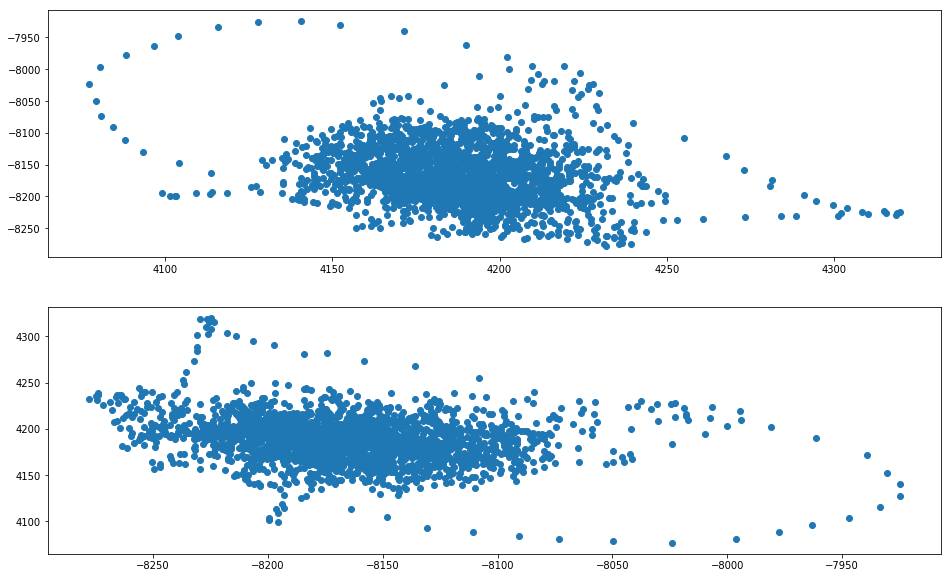

In [110]:
#plt.scatter(s115_116[600*500:605*500],s116_117[600*500:605*500])
plt.figure(figsize=(16,10))
plt.subplot(211)
plt.scatter(s115_116[600*500:605*500],s116_117[600*500:605*500])
plt.subplot(212)
plt.scatter(s116_117[600*500:605*500],s115_116[600*500:605*500])

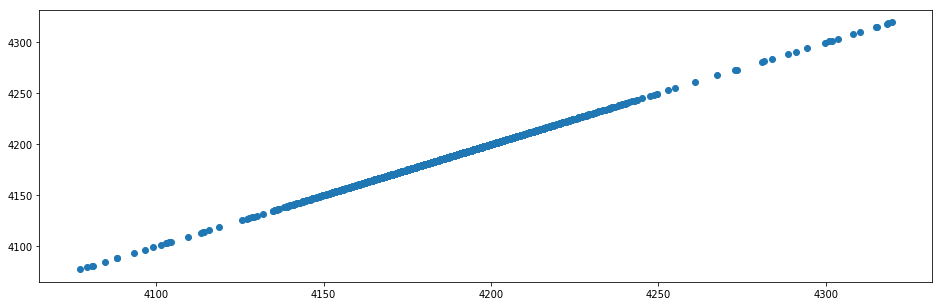

In [108]:
plt.figure(figsize=(16,5))
plt.scatter(s115_116[600*500:605*500],s115_116[600*500:605*500])

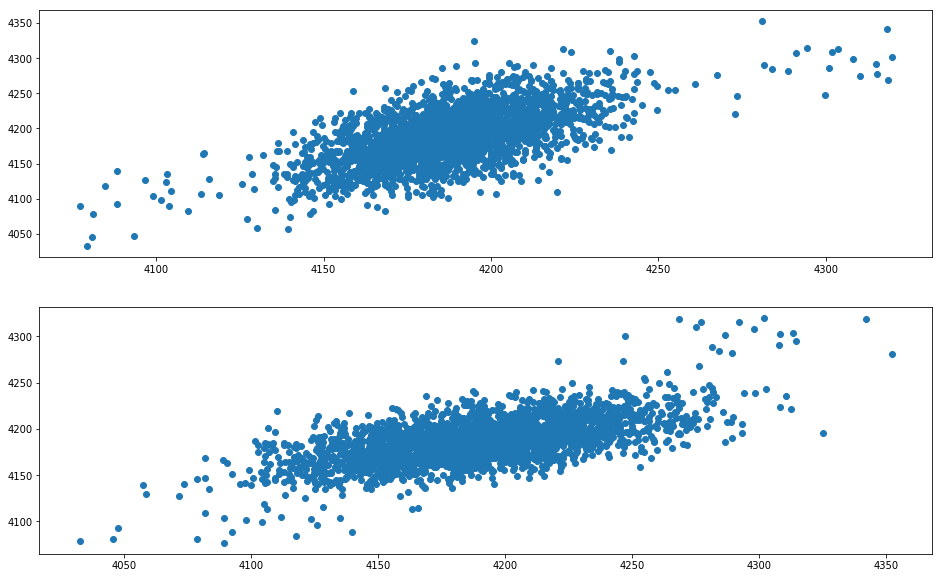

In [105]:
s115_116n = s115_116 + np.random.normal(0, 50, signalSam)
plt.figure(figsize=(16,10))
plt.subplot(211)
plt.scatter(s115_116[600*500:605*500],s115_116n[600*500:605*500])
plt.subplot(212)
plt.scatter(s115_116n[600*500:605*500],s115_116[600*500:605*500])

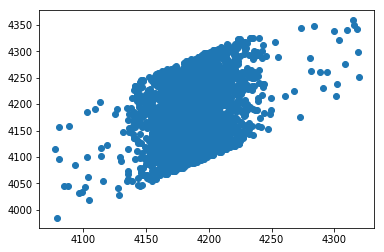

In [100]:
s115_116u = s115_116 + np.random.uniform(-100, 100, signalSam)
plt.scatter(s115_116[600*500:605*500],s115_116u[600*500:605*500])

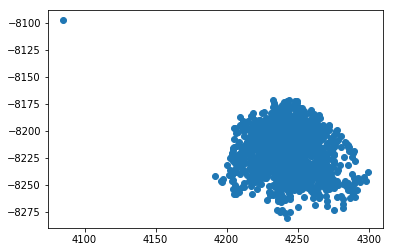

In [29]:
plt.scatter(s115_116[674*500:677*500],s116_117[674*500:677*500])

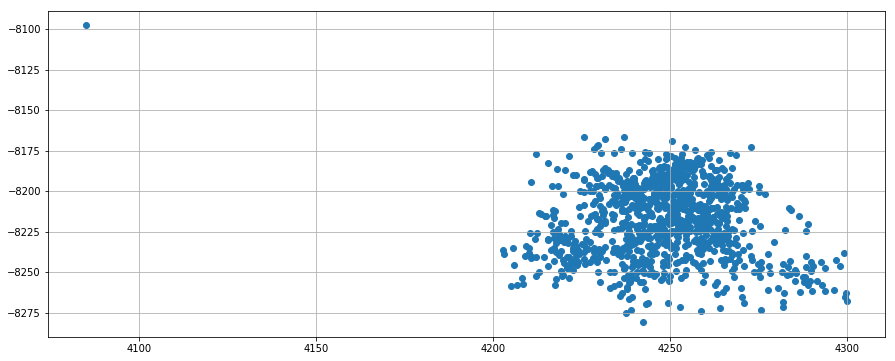

In [118]:
plt.figure(figsize=(15,6))
plt.scatter(s115_116[676*500:678*500],s116_117[676*500:678*500])
plt.grid()

In [34]:
s115_116[np.where(s115_116<4121)]

array([4114.1813077 , 4109.13029679, 4109.39613947, ...,    0.        ,
          0.        ,    0.        ])

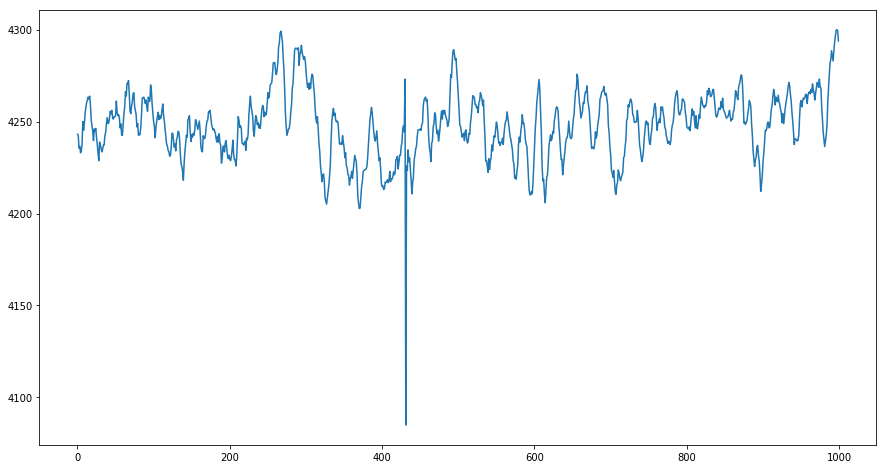

In [115]:
plt.figure(figsize=(15,8))
plt.plot(s115_116[676*500:678*500])

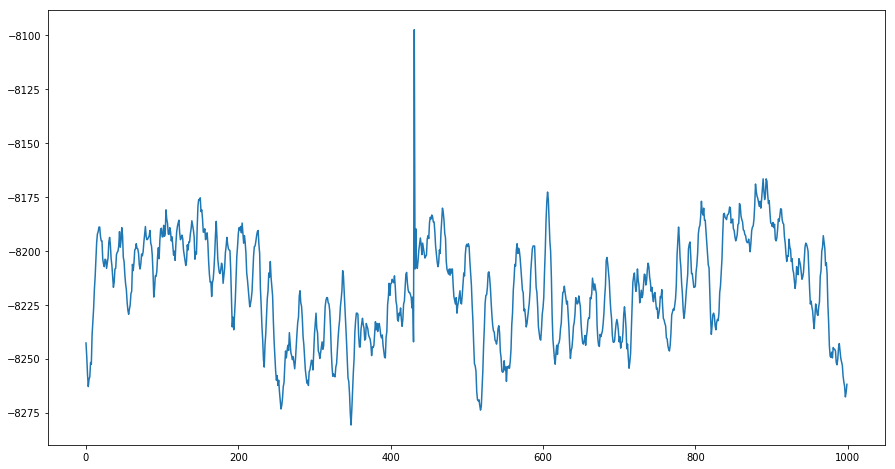

In [119]:
plt.figure(figsize=(15,8))
plt.plot(s116_117[676*500:678*500])

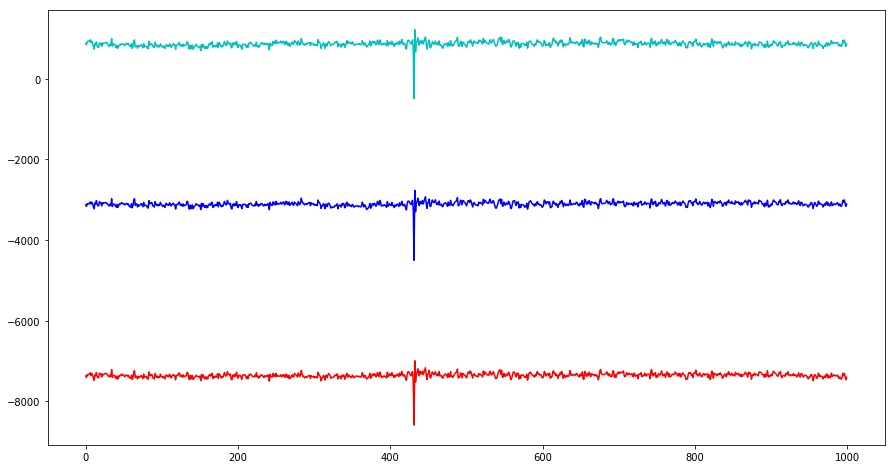

In [121]:
plt.figure(figsize=(15,8))
plt.plot(record[115][676*500:678*500],'b',record[116][676*500:678*500],'r',record[117][676*500:678*500],'c')

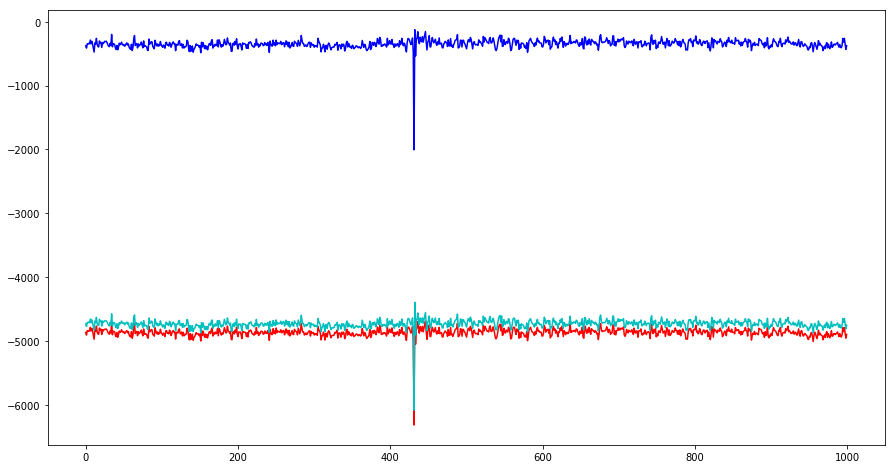

In [122]:
plt.figure(figsize=(15,8))
plt.plot(record[112][676*500:678*500],'b',record[113][676*500:678*500],'r',record[114][676*500:678*500],'c')

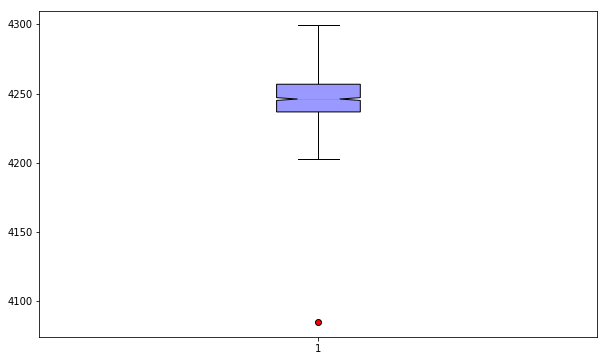

In [73]:
plt.figure(figsize=(10,6))
result=plt.boxplot(s115_116[675*500:677*500],whis=5,flierprops={'marker':'o','markerfacecolor':'r','color':'k'},
           notch=True,patch_artist=True,boxprops={'color':'k','facecolor':'#9999ff'})

In [56]:
q1,q3=np.percentile(s115_116[675*500:677*500],[25,75])

In [57]:
iqr = q3-q1

In [59]:
smin = min(s115_116[675*500:677*500])

In [72]:
q1 - smin > iqr*5

True